# Model Template for amliNet :)

In [1]:
import os
import numpy as np
import pandas as pd
import math

import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Conv2D, Flatten, Concatenate
from keras.preprocessing.image import ImageDataGenerator

from contextlib import redirect_stdout
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

Using TensorFlow backend.


## Global Variables

In [96]:
outcomes = ['No Finding',
            'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
            'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
            'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
            'Support Devices']
pathologies = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
            'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
            'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
            'Support Devices']

#Edit these global variables
PATH = '/Volumes/GBackup/Data/CheXpertDataset'
target = 'Support Devices'

image_size = 256
train_batch_size = 32
val_batch_size = 32
test_batch_size = 234

train_set_size = 10000

lr = 0.0001 #learning rate
num_steps_per_epoch = None #can be set to none for auto choosing
num_epochs = 1

threshold = 0.5

#create the directory before you start!
model_name = 'tester1'
model_directory = model_name+'/' 
if os.path.isdir(model_directory):
    print('Did you mean to rename the model?')
else:
    os.makedirs(model_directory)

Did you mean to rename the model?


### Save the hyperparameters used

In [69]:
hyper_df = pd.DataFrame()
hyper_df['Target'] = [target]
hyper_df['Image size'] = [image_size]
hyper_df['Validation batch size'] = [val_batch_size]
hyper_df['Testing batch size'] = [test_batch_size]
hyper_df['Training batch size'] = [train_batch_size]
hyper_df['Training Size'] = [train_set_size]
hyper_df['Learning Rate'] = [lr]
hyper_df['Steps per epoch'] = [num_steps_per_epoch]
hyper_df['Number of epochs'] = [num_epochs]
hyper_df['Threshold'] = [threshold]

hyper_df.index=[model_name]
t = hyper_df.transpose()
display(t)
t.to_csv(model_directory+'hyperparameters.csv')

,tester
Target,Support Devices
Image size,256
Validation batch size,32
Testing batch size,234
Training batch size,32
Training Size,1000
Learning Rate,0.0001
Steps per epoch,None
Number of epochs,1
Threshold,0.5


## Preprocessing

In [70]:
def edit_urls(url):
    ''' a function to edit the urls to the correct path using a global PATH variable declared earlier
    '''
    pieces = url.split('/')
    newurl = ''

      #removing the previous path 'CheXpert-v1.0-small' and including the PATH
    for i, piece in enumerate(pieces):
        if i > 0:
            newurl+= '/' + piece
        elif i == 0:
            newurl += PATH

    return newurl

def clean_data(df):
    '''
    Edits the urls, fills the 'maybes' with yes and the nulls with no,
    removes outlier ages (age 0 patients), removes 'unknown gender' patients,
    collects which type of image it is
    '''
    df['Path'] = df['Path'].apply(edit_urls)
    df[outcomes] = df[outcomes].fillna(0)
    df[outcomes] = df[outcomes].replace(-1,1)
    df = df[df['Age'] > 1]
    df = df[(df['Sex'] == 'Male') | (df['Sex'] == 'Female')]
    df['Image Type'] = df['AP/PA'].fillna('Lateral')
    return df


In [78]:
train_df = clean_data( pd.read_csv(PATH + '/train.csv') )
test_df = clean_data( pd.read_csv(PATH + '/valid.csv'))


#can chose a subset here
train_df = train_df.sample(train_set_size)

#for keras, make the target a string
train_df[target] = train_df[target].apply(str)
test_df[target] = test_df[target].apply(str)

print('test set:', test_df.shape)
print('training set:', train_df.shape)
train_df.head(3)

test set: (234, 20)
training set: (10000, 20)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Image Type
162763,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Female,75,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,AP
10203,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Male,22,Frontal,PA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PA
92900,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Male,72,Lateral,NaN,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,Lateral


## Prepare the Model

In [79]:
datagen = ImageDataGenerator(
   rescale = 1./255,
   validation_split = 0.2
)

train_generator = datagen.flow_from_dataframe(
   train_df,
   x_col='Path',
   y_col=target,
   color_mode='grayscale', # images will be converted to have 1 color channel
   target_size=(image_size, image_size), #The dimensions to which all images found will be resized
   class_mode='binary', # Mode for yielding the targets 1D numpy array of binary labels,if class_mode is "binary" it must include the given y_col column with class values as strings.
   batch_size=train_batch_size,
   subset = "training"
   #shuffle: whether to shuffle the data (default: True)
)

validation_generator = datagen.flow_from_dataframe(
   train_df,
   x_col='Path',
   y_col=target,
   target_size=(image_size, image_size),
   color_mode='grayscale',
   class_mode='binary',
   batch_size=val_batch_size,
   subset = "validation"
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='Path',
    y_col=target,
    target_size=(image_size, image_size),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=test_batch_size,
    shuffle = False #just in case
)

Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 234 validated image filenames belonging to 2 classes.


## Edit your model here

### To create a model

In [80]:
model = tf.keras.Sequential([
   tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(image_size,image_size,1)),
   tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
   tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
   tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
   tf.keras.layers.Flatten(),
   tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

### To load a model

In [ ]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        model = load_model(model_name+'.h5')

### Compile the model

(all models need to be compiled)

In [81]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=tf.train.AdamOptimizer(learning_rate = lr),
  metrics=['accuracy']
)

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 492034    
Total params: 510,850
Trainable params: 510,850
Non-trainable params: 0
________________________________________________

Save the model summary

In [82]:
with open(model_directory + 'model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

## Run the model

### Train the model

(only necessary when you are creating a model, not loading a model)

In [83]:
# uses some global variables
history = model.fit_generator(train_generator,
    steps_per_epoch = num_steps_per_epoch, 
    epochs = num_epochs,
    validation_data = validation_generator
)

250/250 [==============================] - 567s 2s/step - loss: 0.6650 - acc: 0.6059 - val_loss: 0.6380 - val_acc: 0.6435


### Make Predictions

(be patient)

In [84]:
predictions = model.predict_generator(test_generator, steps = len(test_generator))
print(f'made {len(predictions)} predictions')

# This checks the row that is related to 'being sick' (... hopefully)
probability_sick = predictions.T[1]
print(probability_sick[0:10].round())
actual_labels = test_generator[0][1]
print(actual_labels[0:10])

made 234 predictions
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]


### Save the Model

In [85]:
model.save(model_directory + model_name + '.h5')

print('Model saved in', model_directory)

W0723 16:13:55.592891 140736020484992 hdf5_format.py:110] TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file. You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).


Model saved in tester/


## Do metrics

In [86]:
def get_confusion_matrix(predictions, actuals, threshold):
    """
    Returns a confusion matrix whose rows correspond to predicted outputs and
       whose columns correspond to actual outputs.

    predictions: 1D numpy array.
    actuals: 1D numpy array.
    threshold: float, value above which predictions are classified as positive,
       below which predictions are classified as negative.
    """
    bool_predictions = (predictions > threshold)
    bool_actuals = (actuals > threshold)

    return confusion_matrix(bool_predictions, bool_actuals)

In [87]:
def get_metrics(predictions, actuals, threshold):
    """
    Prints all metrics associated with the model output.

    predictions: 1D numpy array.
    actuals: 1D numpy array.
    threshold: float, value above which predictions are classified as positive,
       below which predictions are classified as negative.
    """
    TP, FP, FN, TN = get_confusion_matrix(predictions, actuals, threshold).ravel()

    trues = TP + TN
    wrongs = FP + FN
    sensitivity = TP / (TP + FN) # This is also recall
    specificity = TN / (TN + FP)
    precision = TP / (TP +FP)
    accuracy = (TP + TN) / (TP + TN + FP +FN)
    F1 = 2 / ((1 / precision) + (1 / sensitivity))
    
    metrics_df = pd.DataFrame()
    metrics_df['Correct Predictions'] = [trues]
    metrics_df['Incorrect Predictions'] = [wrongs]
    metrics_df['Sensitivity'] = [sensitivity]
    metrics_df['Specificity'] = [specificity]
    metrics_df['Precision'] = [precision]
    metrics_df['Accuracy'] = [accuracy]
    metrics_df['F1 score'] = [F1]
    metrics_df.index = [model_name]
    metrics_df
    t = metrics_df.transpose()
    t.to_csv(model_directory+'metrics.csv')
    display(t)
    
    return

In [88]:
def get_roc_curve(predictions, actuals):
    """
    Plots the ROC curve and associated AUC of the model output.

    predictions: 1D numpy array.
    actuals: 1D numpy array.
    """
    FPR, TPR, thresholds = roc_curve(actuals, predictions)
    AUC = roc_auc_score(actuals, predictions)

    plt.plot(FPR, TPR, "b-")
    plt.plot([0, 1], [0, 1], "r--")
    plt.title("Receiver Operating Characteristic \n AUC: {}".format(AUC))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.ylabel("Sensitivity")
    plt.xlabel("1 - Specificity")
    plt.savefig(model_directory+'ROC_curve.png')
    plt.show()
    
    return

In [89]:
def get_precision_recall_curve(predictions, actuals):
    """
    Plots the precision-recall curve and associated AUC of the model output.

    predictions: 2D numpy array.
    actuals: 1D numpy array.
    """
    precisions, recalls, thresholds = precision_recall_curve(actuals, predictions)
    AUC = auc(recalls, precisions)

    plt.plot(recalls, precisions, "b-")
    plt.plot([0, 1], [1, 0], "r--")
    plt.title("Precision-Recall Curve \n AUC: {}".format(AUC))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.ylabel("Recall")
    plt.xlabel("Precision")
    plt.savefig(model_directory+'precision_recall_curve.png')
    plt.show()
    
    return 'saved precision recall curve'


In [90]:
def display_conf_mat(predictions, actuals, threshold):
    '''
    Displays and saves the confusion matrix
    '''
    cm = get_confusion_matrix(predictions, actuals, threshold)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap=plt.cm.Blues,fmt='g') #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.savefig(model_directory + 'confusion_matrix.png')
    plt.show()
    
    return 'saved confusion matrix'

## Run the Metrics

,tester
Correct Predictions,147.000000
Incorrect Predictions,87.000000
Sensitivity,0.732283
Specificity,0.504673
Precision,0.636986
Accuracy,0.628205
F1 score,0.681319


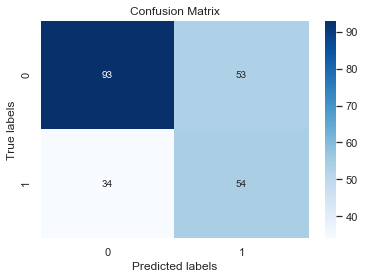

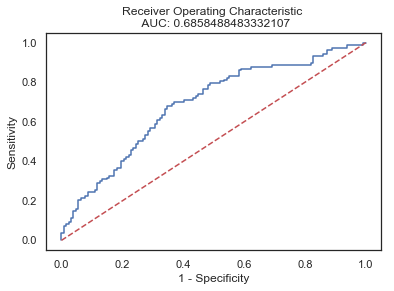

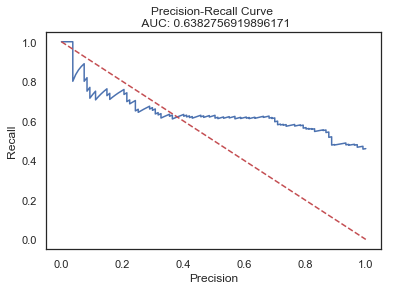

'saved precision recall curve'

In [91]:
get_metrics(probability_sick, actual_labels, threshold)
display_conf_mat(probability_sick, actual_labels, threshold)
get_roc_curve(probability_sick, actual_labels)
get_precision_recall_curve(probability_sick, actual_labels)

## Prediction Visualization


In [92]:
def plot_image(i, probability_sick, actual_labels, images_bucket, threshold):
    '''
    Plots images next to labels, color coded based on if they were correct or not.
    '''
    prob_sick = probability_sick[i]
    true_label = int(actual_labels[i])

    # Remove grid, x and y axis ticks from the chart
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Plot the image
    plt.imshow( images_bucket[i, :, :, 0], cmap='gray')

    if prob_sick > threshold:
        predicted_label = 1
    else:
        predicted_label = 0
    
    # Set color to blue on a correct prediction, otherwise set color to red
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    class_names = ['Not '+target, target ]
    # Print the predicted label, confidence number, and actual label
    plot_label = f"Predicted probability of {target} is {round(100*prob_sick, 2)}%, " + \
            f"\n so we predict {class_names[predicted_label]} " + \
            f"\n while true label is {class_names[true_label]}"
    plt.xlabel(plot_label,color=color)

Probability of sickness: 44.56%  Actual label: 0
Probability of sickness: 37.71%  Actual label: 1
Probability of sickness: 25.39%  Actual label: 1
Probability of sickness: 57.47%  Actual label: 0
Probability of sickness: 40.54%  Actual label: 0
Probability of sickness: 39.21%  Actual label: 0
Probability of sickness: 43.5%  Actual label: 1
Probability of sickness: 35.75%  Actual label: 0
Probability of sickness: 31.6%  Actual label: 0
Probability of sickness: 17.72%  Actual label: 0
Probability of sickness: 44.04%  Actual label: 0
Probability of sickness: 51.8%  Actual label: 1


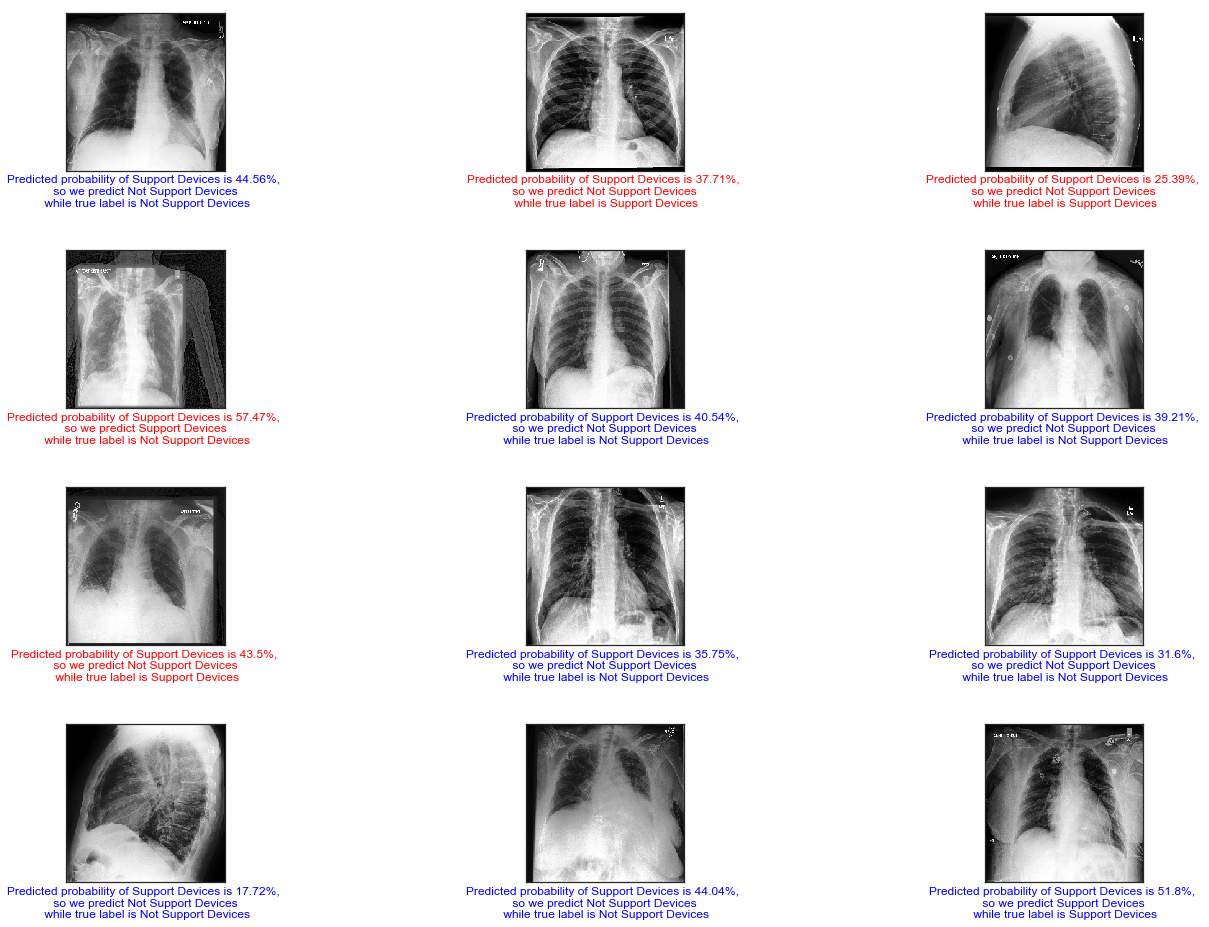

In [93]:
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols


fig = plt.figure(figsize=(4*2*num_cols, 4*num_rows))
fig.subplots_adjust(hspace=.5)

images_bucket = test_generator[0][0]

for i in range(num_images):
    print(f'Probability of sickness: {round(100* probability_sick[i], 2)}%  Actual label: {int(actual_labels[i])}')
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, probability_sick, actual_labels, images_bucket, threshold)
    
plt.savefig(model_directory+'sample_boobs.pdf')